In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re,string,unicodedata
import keras
import tensorflow as tf
import time
import warnings
import lxml
import re

from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
from string import punctuation

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import ToktokTokenizer
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack



[nltk_data] Downloading package wordnet to C:\Users\Moment
[nltk_data]     Home\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read Data

use pandas to read csv files and print head

In [5]:
path_prefix = './data'
warnings.filterwarnings('ignore')

read the CSV files to get the question info

In [6]:
df_questions = pd.read_csv(path_prefix+"/Questions.csv",encoding="ISO-8859-1")
df_questions.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [7]:
df_tags = pd.read_csv(path_prefix+"/Tags.csv",encoding="ISO-8859-1",dtype={'Tag':str})
df_tags.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


## Process tags

In [8]:
type(df_tags)

pandas.core.frame.DataFrame

In [9]:
type(df_tags['Tag'][0])

str

In [10]:
df_tags['Tag']=df_tags['Tag'].astype(str)

In [11]:
a = df_tags.groupby('Id')

In [12]:
a.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn
...,...,...
3750989,40143360,javascript
3750990,40143360,vue.js
3750991,40143380,npm
3750992,40143380,mocha


In [13]:
b = a['Tag'].apply(lambda tags: ' '.join(tags))

In [14]:
b.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [15]:
b.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [16]:
b = b.reset_index()

In [17]:
b.index

RangeIndex(start=0, stop=1264216, step=1)

In [18]:
b.values

array([[80, 'flex actionscript-3 air'],
       [90, 'svn tortoisesvn branch branching-and-merging'],
       [120, 'sql asp.net sitemap'],
       ...,
       [40143340, 'android android-studio'],
       [40143360, 'javascript vue.js'],
       [40143380, 'npm mocha babel']], dtype=object)

In [19]:
b['Id']

0                80
1                90
2               120
3               180
4               260
             ...   
1264211    40143210
1264212    40143300
1264213    40143340
1264214    40143360
1264215    40143380
Name: Id, Length: 1264216, dtype: int64

In [20]:
grouped_tags_final = pd.DataFrame({'Id':b['Id'],'Tags':b['Tag']})
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


## Process questions

In [21]:
df_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [22]:
df_questions.drop(columns=['OwnerUserId','CreationDate','ClosedDate'],inplace=True)


drop()函数中inplace参数使用，默认为False.
inplace = True：不创建新的对象，直接对原始对象进行修改； inplace = False：对数据进行修改，创建并返回新的对象承载其修改结果

In [23]:
df_questions.head()

,Id,Score,Title,Body
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


then merge the tags into the one table

In [24]:
df = df_questions.merge(grouped_tags_final,on='Id')
df.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


Then, I will drop the questions whose score lower than 5. The reeasons are as follows:

1- reduce the computational resources form kaggle.

2- the post will probability be with a better quality and will better tagged since they have lots of upvotes.

In [25]:
result = df['Score'].describe()
pd.DataFrame(result)

,Score
count,1.264216e+06
mean,1.781537e+00
std,1.366389e+01
min,-7.300000e+01
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,5.190000e+03


### Visualization for score

In [26]:
sum(df['Score']>5)

72950

In [27]:
type(df['Score'][0])

numpy.int64

#### Using the sampling to view the distribution of score

In [28]:
index = np.random.randint(0,1264216,size = 10000)
df['Score'][index]

503489      0
33063      15
453299      0
990165      1
736096     -1
           ..
1210210     0
1075550     0
7535        0
752859      1
568126      0
Name: Score, Length: 10000, dtype: int64

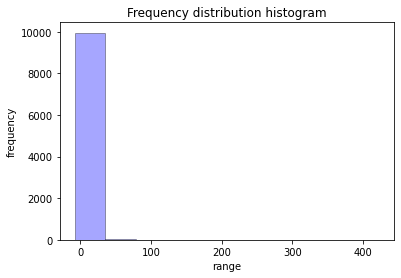

In [29]:
#直方图📊
plt.hist(df['Score'][index],facecolor='blue',edgecolor='black',alpha=0.35)
plt.xlabel('range')
plt.ylabel('frequency')
plt.title('Frequency distribution histogram')
#my_x_ticks = np.arange(0, 100, 50)

#plt.xticks(my_x_ticks)
plt.show()

(-10.0, 10.0)

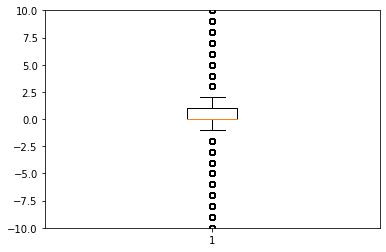

In [30]:
plt.boxplot(df['Score'])
plt.ylim(-10, 10)

In [31]:
new_df = df[df['Score']>5]
new_df.head()

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [32]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72950 entries, 0 to 1264205
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      72950 non-null  int64 
 1   Score   72950 non-null  int64 
 2   Title   72950 non-null  object
 3   Body    72950 non-null  object
 4   Tags    72950 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.3+ MB


In [33]:
result = new_df['Score'].describe()
pd.DataFrame(result)

,Score
count,72950.000000
mean,19.851295
std,53.461874
min,6.000000
25%,7.000000
50%,10.000000
75%,17.000000
max,5190.000000


there is no missing values or duplocated values

In [34]:
print('Duplicate entries:{}'.format(new_df.duplicated().sum()))


Duplicate entries:0


In [35]:
new_df.drop_duplicates(inplace=True)

This is a very good dataset since there are no missing values or duplicated values.

In [36]:
new_df.drop(columns=['Id','Score'],inplace=True)

In [37]:
new_df

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction
...,...,...,...
1262915,How to use a dict to subset a DataFrame?,"<p>Say, I have given a DataFrame with most of ...",python pandas dataframe categorical-data
1263065,Is there a way to use itertools in python to c...,<p>Let's say I have the following code:</p>\n\...,python iterator nested-loops itertools
1263399,How can I force file ordering in F# projects u...,<p>I'm trying to work with vscode in my WebSha...,f# vscode
1263454,Why does my result data returned as void* gets...,<p>I am working in a project with a huge legac...,c++


### -  Tags

In [38]:
type(new_df['Tags'].values)

numpy.ndarray

In [39]:
new_df['Tags']=new_df['Tags'].apply(lambda x: x.split())

In [40]:
new_df.head(5)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"


In [41]:
q = [item for item in new_df['Tags']]
q

[['flex', 'actionscript-3', 'air'],
 ['svn', 'tortoisesvn', 'branch', 'branching-and-merging'],
 ['sql', 'asp.net', 'sitemap'],
 ['algorithm', 'language-agnostic', 'colors', 'color-space'],
 ['c#', '.net', 'scripting', 'compiler-construction'],
 ['c++', 'oop', 'class', 'nested-class'],
 ['.net', 'web-services'],
 ['sql-server', 'sql-server-2005', 'deployment', 'release-management'],
 ['c#', 'visual-studio', 'versioning'],
 ['windows', 'visual-studio', 'registry', 'installation'],
 ['c#', 'database', 'loops', 'connection'],
 ['c#', 'asp.net'],
 ['c#', 'file-locking'],
 ['unix', 'size'],
 ['svn', 'msbuild', 'cruisecontrol.net'],
 ['web-applications', 'dns', 'subdomain', 'account'],
 ['.net', '.net-3.5', 'msbuild', 'nant'],
 ['sql-server', 'windows-server-2008'],
 ['sql-server', 'sql-server-2008'],
 ['sql-server'],
 ['c#', '.net', 'unit-testing', 'testing'],
 ['svn', 'version-control'],
 ['sql', 'database', 'postgresql', 'stored-procedures', 'triggers'],
 ['sql', 'sql-server'],
 ['c#', 'd

In [42]:
all_tags = [item for sublist in new_df['Tags'] for item in sublist]
all_tags

['flex',
 'actionscript-3',
 'air',
 'svn',
 'tortoisesvn',
 'branch',
 'branching-and-merging',
 'sql',
 'asp.net',
 'sitemap',
 'algorithm',
 'language-agnostic',
 'colors',
 'color-space',
 'c#',
 '.net',
 'scripting',
 'compiler-construction',
 'c++',
 'oop',
 'class',
 'nested-class',
 '.net',
 'web-services',
 'sql-server',
 'sql-server-2005',
 'deployment',
 'release-management',
 'c#',
 'visual-studio',
 'versioning',
 'windows',
 'visual-studio',
 'registry',
 'installation',
 'c#',
 'database',
 'loops',
 'connection',
 'c#',
 'asp.net',
 'c#',
 'file-locking',
 'unix',
 'size',
 'svn',
 'msbuild',
 'cruisecontrol.net',
 'web-applications',
 'dns',
 'subdomain',
 'account',
 '.net',
 '.net-3.5',
 'msbuild',
 'nant',
 'sql-server',
 'windows-server-2008',
 'sql-server',
 'sql-server-2008',
 'sql-server',
 'c#',
 '.net',
 'unit-testing',
 'testing',
 'svn',
 'version-control',
 'sql',
 'database',
 'postgresql',
 'stored-procedures',
 'triggers',
 'sql',
 'sql-server',
 'c#',
 

In [43]:
len(all_tags)

224129

In [44]:
my_set = set(all_tags)
len(my_set)

14883

In [45]:
type(my_set)

set

In [46]:
unique_tags = list(my_set)
len(unique_tags)

14883

In [47]:
#count the word frequency stastistics
flat_list = [item for sublist in new_df['Tags'] for item in sublist]
len(flat_list)

keywords = nltk.FreqDist(flat_list)

FreqDist(words_list), 接受list类型的参数，返回字典，key是元素，value是元素出现的次数

In [48]:
keywords

FreqDist({'c#': 6907, 'java': 6862, 'javascript': 5560, 'android': 5052, 'python': 4442, 'c++': 4369, 'php': 3024, 'jquery': 2770, '.net': 2705, 'ios': 2685, ...})

In [49]:
frequencies_words=keywords.most_common(100)

In [50]:
hot_tags = [item[0] for item in frequencies_words[:10]]
hot_tags 


['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios']

In [51]:
hot_tags_nums = [item[1] for item in frequencies_words[:10]]
hot_tags_nums 

[6907, 6862, 5560, 5052, 4442, 4369, 3024, 2770, 2705, 2685]

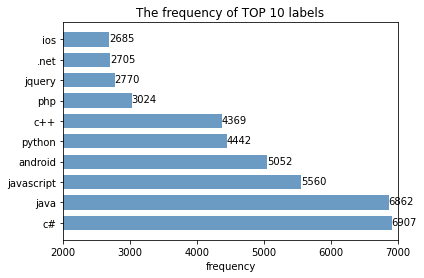

In [52]:
#参数一：y轴 参数二：x轴
plt.barh(range(10),hot_tags_nums,height = 0.7,color = 'steelblue',alpha =0.8)
plt.yticks(range(10),hot_tags)
plt.xlim(2000,7000)
for x, y in enumerate(hot_tags_nums):
    plt.text(y + 0.2, x - 0.1, '%s' % y)
plt.xlabel('frequency')
plt.title('The frequency of TOP 10 labels')
plt.show()

In [53]:
keyword = nltk.FreqDist(keywords)
keyword

FreqDist({'c#': 6907, 'java': 6862, 'javascript': 5560, 'android': 5052, 'python': 4442, 'c++': 4369, 'php': 3024, 'jquery': 2770, '.net': 2705, 'ios': 2685, ...})

In [54]:
#most_common()函数 
# most_common(n)按照降序，返回前n项组成的list; n忽略时返回全部
frquencies_words = keyword.most_common(100)
tag_features = [word[0] for word in frequencies_words]

In [107]:
frequencies_words[:10]

[('c#', 6907),
 ('java', 6862),
 ('javascript', 5560),
 ('android', 5052),
 ('python', 4442),
 ('c++', 4369),
 ('php', 3024),
 ('jquery', 2770),
 ('.net', 2705),
 ('ios', 2685)]

In [56]:
tag_features

['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios',
 'html',
 'css',
 'c',
 'iphone',
 'objective-c',
 'ruby-on-rails',
 'sql',
 'asp.net',
 'mysql',
 'ruby',
 'r',
 'git',
 'asp.net-mvc',
 'linux',
 'sql-server',
 'node.js',
 'angularjs',
 'django',
 'performance',
 'algorithm',
 'string',
 'xcode',
 'arrays',
 'wpf',
 'eclipse',
 'haskell',
 'windows',
 'scala',
 'multithreading',
 'json',
 'c++11',
 'regex',
 'visual-studio',
 'html5',
 'osx',
 'swift',
 'database',
 'unit-testing',
 'spring',
 'xml',
 'bash',
 'ajax',
 'delphi',
 'cocoa-touch',
 'ruby-on-rails-3',
 'visual-studio-2010',
 'linq',
 'debugging',
 'generics',
 'perl',
 'entity-framework',
 'mongodb',
 'winforms',
 'cocoa',
 'security',
 'postgresql',
 'css3',
 'templates',
 'twitter-bootstrap',
 'shell',
 'list',
 'google-chrome',
 'vim',
 'oop',
 'image',
 'hibernate',
 'gcc',
 'asp.net-mvc-3',
 'facebook',
 'oracle',
 'rest',
 'maven',
 'http',
 'exception',
 'tsql',
 'ma

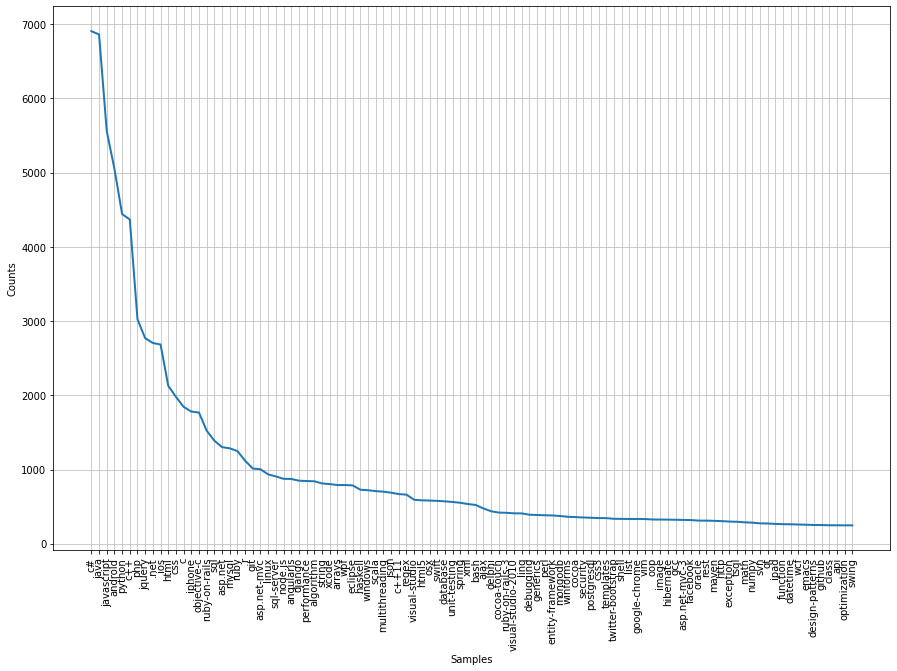

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [57]:
fig , ax = plt.subplots(figsize = (15,10))
keyword.plot(100,cumulative = False)
#cumulative：whether to count the cumulative frequenceies

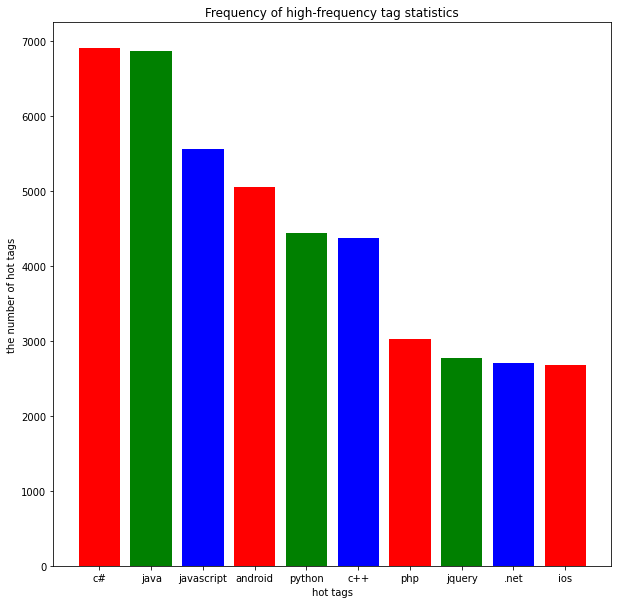

In [58]:
plt.figure(figsize=(10,10))
plt.bar(hot_tags,hot_tags_nums,color='rgb',tick_label=hot_tags)

plt.xlabel('hot tags')
plt.ylabel('the number of hot tags')
plt.title('Frequency of high-frequency tag statistics')
plt.show()

In [59]:
new_df.head(5)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"


In [60]:
def common_f(tags):
    tags_filtered = []
    for i in range(0,len(tags)):
        if tags[i] in tag_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [61]:
new_df['Tags'] = new_df['Tags'].apply(lambda s: common_f(s))

In [62]:
new_df['Tags']

0                      []
1                   [svn]
2          [sql, asp.net]
3             [algorithm]
4              [c#, .net]
                ...      
1262915          [python]
1263065          [python]
1263399                []
1263454             [c++]
1264205         [haskell]
Name: Tags, Length: 72950, dtype: object

In [63]:
new_df['Tags']=new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [64]:
new_df['Tags']

0                    None
1                   [svn]
2          [sql, asp.net]
3             [algorithm]
4              [c#, .net]
                ...      
1262915          [python]
1263065          [python]
1263399              None
1263454             [c++]
1264205         [haskell]
Name: Tags, Length: 72950, dtype: object

In [65]:
new_df.shape

(72950, 3)

In [66]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72950 entries, 0 to 1264205
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   72950 non-null  object
 1   Body    72950 non-null  object
 2   Tags    63167 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


In [67]:
new_df.dropna(subset=['Tags'],inplace=True)

In [68]:
print(new_df.shape)
new_df.head(5)

(63167, 3)


,Title,Body,Tags
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]"


### - Body

#### do some text processing 
1、Removing htmi format

2、Lowering text

3、removing the punctuation

4、lemmatizing words(词性还原

5、Removing stop words

In [69]:
#converting html to text in the body
new_df['Body'] = new_df['Body'].apply(lambda x:BeautifulSoup(x).get_text())

In [70]:
new_df.head(5)

,Title,Body,Tags
1,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...,[svn]
2,ASP.NET Site Maps,Has anyone got experience creating SQL-based A...,"[sql, asp.net]"
3,Function for creating color wheels,This is something I've pseudo-solved many time...,[algorithm]
4,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...,"[c#, .net]"
5,Should I use nested classes in this case?,I am working on a collection of classes used f...,"[c++, oop, class]"


In [71]:
#re.sub()函数用于替换字符串中的匹配项
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's","what is", text)
    text = re.sub(r"\'s'"," ",text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [72]:
new_df['Body'] = new_df['Body'].apply(lambda a:clean_text(a))

In [73]:
new_df.head(5)

,Title,Body,Tags
1,Good branching and merging tutorials for Torto...,are there any really good tutorials explaining...,[svn]
2,ASP.NET Site Maps,has anyone got experience creating sql-based a...,"[sql, asp.net]"
3,Function for creating color wheels,this is something i have pseudo-solved many ti...,[algorithm]
4,Adding scripting functionality to .NET applica...,i have a little game written in c#. it uses a ...,"[c#, .net]"
5,Should I use nested classes in this case?,i am working on a collection of classes used f...,"[c++, oop, class]"


In [74]:
token =ToktokTokenizer()

In [75]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [76]:
punct='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [77]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item,'strip') else item for item in mylist)
    return [item for item in newlist if item !='']
    #hasattr(object, name)判断对象是否有该属性，返回True或者False
    #strip()去除首尾空格

In [78]:
def clean_punc(text):
    words = token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]'% re.escape(punct))
    remove_punctuation = str.maketrans(' ',' ',punct)
    for w in words:
        if w in tag_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub(' ',w))
    filtered_list=strip_list_noempty(punctuation_filtered)
    return (' '.join(map(str, filtered_list)))

In [79]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punc(x)) 

In [80]:
new_df['Body'][2]

'has anyone got experience creating sql based asp.net site map providers i have got the default xml file web sitemap working properly with my menu and sitemappath controls but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well'

In [81]:
import nltk
nltk.download('stopwords')
lemma = WordNetLemmatizer()
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Moment
[nltk_data]     Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
def lemitizeWords(text):
    words = token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w,pos='v')
        listLemma.append(x)
    return ' '.join(map(str,listLemma))

In [83]:
def stopWordsRemove(text):
    stop_words = set(stopwords.words("english"))
    words=token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str,filtered))

In [84]:
new_df['Body']=new_df['Body'].apply(lambda x: lemitizeWords(x))
new_df['Body']=new_df['Body'].apply(lambda x: stopWordsRemove(x))

### -Title

In [85]:
new_df['Title'].head()

1    Good branching and merging tutorials for Torto...
2                                    ASP.NET Site Maps
3                   Function for creating color wheels
4    Adding scripting functionality to .NET applica...
5            Should I use nested classes in this case?
Name: Title, dtype: object

In [86]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punc(x))
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x))
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x))


### -EDA

In [87]:
no_topics=20

In [88]:
text = new_df['Body']

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [90]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',min_df=0.0,max_df=1.0,strip_accents=None,
                                  encoding='utf-8', preprocessor=None,token_pattern=r"(?u)\S\S+",
                                  max_features=1000
                                 )

In [91]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [92]:
from sklearn.decomposition import LatentDirichletAllocation

In [93]:
lda = LatentDirichletAllocation(n_components=no_topics,max_iter=5,learning_method='online',learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [94]:
def display_topics(model,feature_names,no_stop_words):
    for topic_idx, topic in enumerate(model.components_):
        print("------------------------------------------")
        print("Topic %d:"%(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
        print("------------------------------------------")
        
no_top_words =10
display_topics(lda,vectorizer_train.get_feature_names(),no_top_words)

------------------------------------------
Topic 0:
project file build error install use run studio android package
------------------------------------------
------------------------------------------
Topic 1:
table id 124 query select data database sql row name
------------------------------------------
------------------------------------------
Topic 2:
android matrix drawable notification textview icon widget nsstring linearlayout androidruntime
------------------------------------------
------------------------------------------
Topic 3:
file python py import plot module path line pdf txt
------------------------------------------
------------------------------------------
Topic 4:
xcode apple rb lib iphone usr ref temp 2011 env
------------------------------------------
------------------------------------------
Topic 5:
thread run use process time application app task memory call
------------------------------------------
------------------------------------------
Topic 6:
div b

### Classical classifiers

### - Data preparation
- Binarize the tags
- Use a TFIDF for body and Title

In [95]:
X1 = new_df['Body']
X2 = new_df['Title']
y = new_df['Tags']

multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [96]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',min_df =0.0,max_df =1.0,strip_accents=None,encoding='utf-8',preprocessor=None,token_pattern=r"(?u)\S\S+",max_features=1000)
vectorizer_X2 = TfidfVectorizer(analyzer = 'word',min_df=0.0,max_df=1.0,strip_accents=None,encoding='utf-8',preprocessor = None,token_pattern=r"(?u)\S\S+",max_features=1000)

In [97]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [98]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [99]:
X_train,X_test,y_train,y_test = train_test_split(X_tfidf,y_bin,test_size=0.2,random_state=0)